In [189]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils

In [190]:
def show_img(img):
    fig = plt.gcf()
    fig.set_size_inches(16, 8)
    plt.axis(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

(1600, 1200)


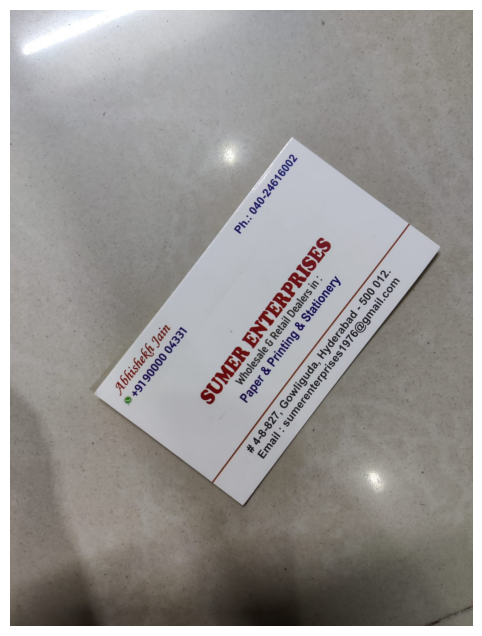

In [191]:
img_original = cv2.imread('images/03.jpg')
print(img_original.shape[:2])
show_img(img_original)

## Scanning

### 1. Resize the image and set aspect ratio

In [192]:
def resizer(image, width=500):
    h, w = image.shape[:2]
    height = int((h/w) * width)
    size = (width, height)
    image = cv2.resize(image, (width, height))
    return image, size

(500, 666)


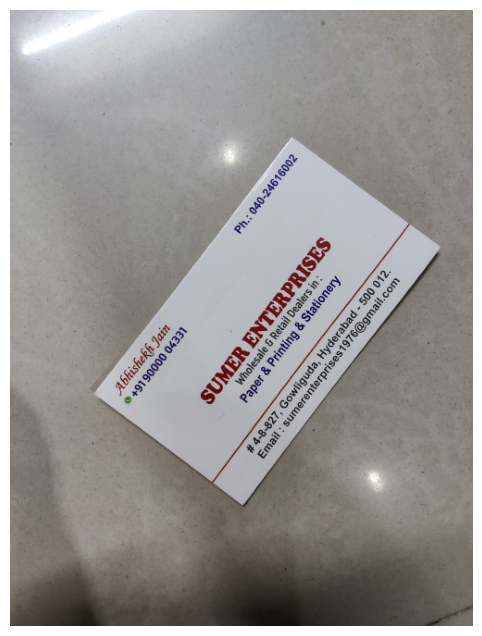

In [193]:
img_re, size = resizer(img_original)
print(size)
show_img(img_re)

### 2. Image Processing
1. Enhance
2. Grayscale
3. Blur
4. Edge Detect
5. Morphological Transform
6. Contours
7. Find Four Points

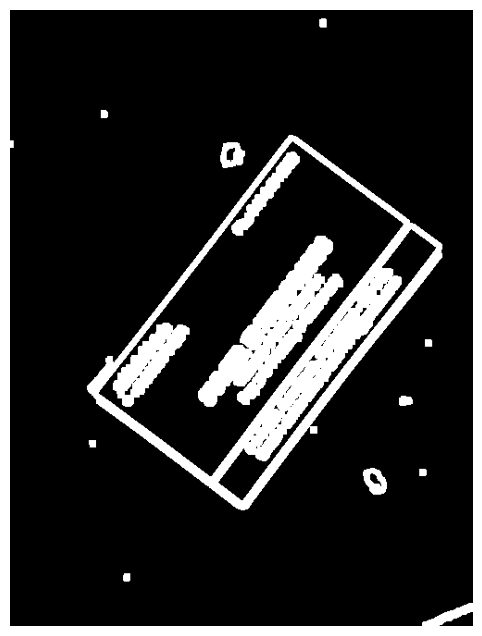

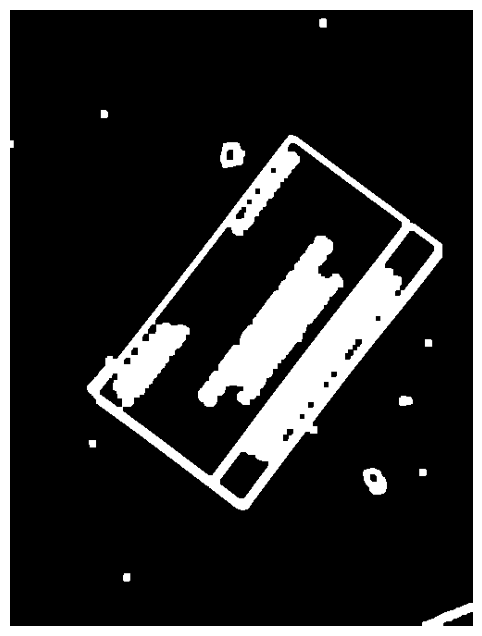

In [194]:
detail = cv2.detailEnhance(img_re, sigma_s=20, sigma_r=0.15)
gray = cv2.cvtColor(detail, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Edge
edge_img = cv2.Canny(blur, 60, 180)

# Morphological
kernel = np.ones((5, 5), np.uint8)
dilate = cv2.dilate(edge_img, kernel, iterations=1)
closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel)

show_img(dilate)
show_img(closing)

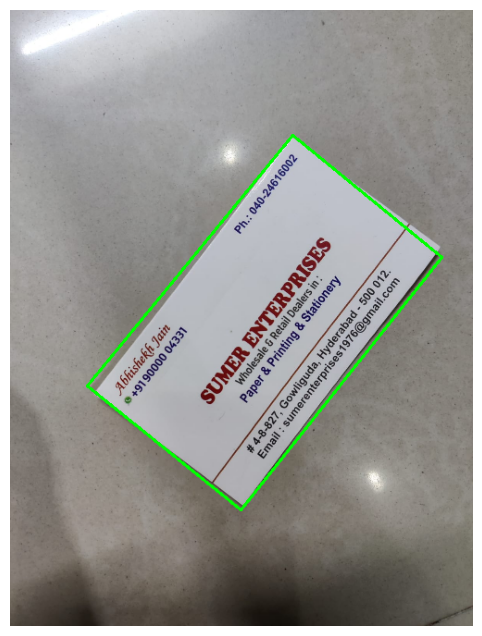

In [195]:
# Find contour
contours, hire = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
for cnt in contours:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    
    if len(approx) == 4:
        four_points = np.squeeze(approx)
        break

cv2.drawContours(img_re, [four_points], -1, (0, 255, 0), 2)
show_img(img_re)

In [196]:
## Find four points for original image
multiplier = img_original.shape[1] / size[0]
four_points_original = (four_points * multiplier).astype(int)
four_points_original

array([[ 732,  324],
       [ 199,  974],
       [ 597, 1296],
       [1118,  640]])

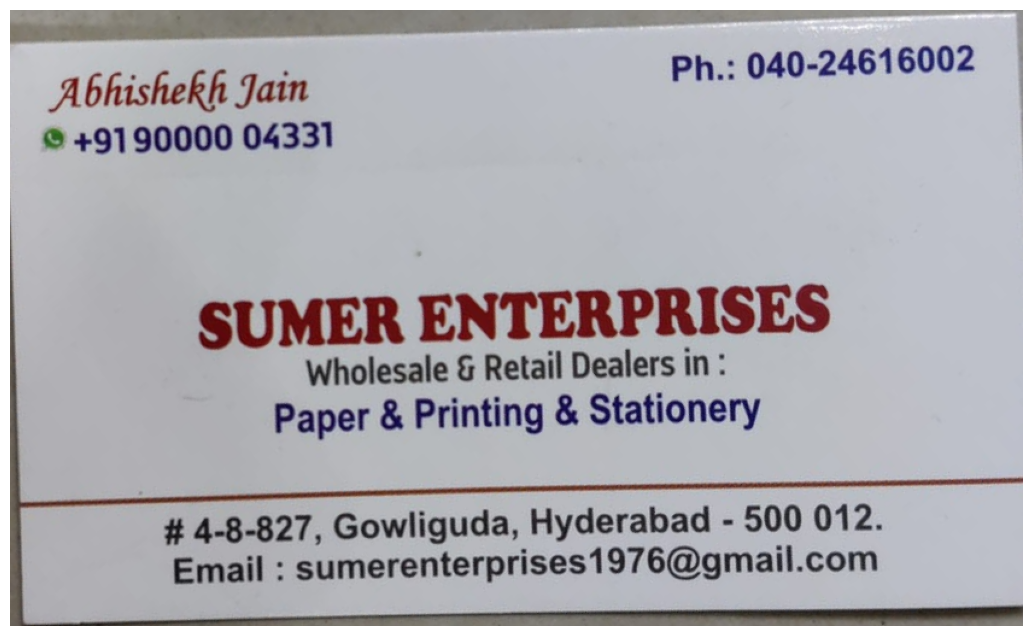

In [197]:
from imutils.perspective import four_point_transform

wrap_image = four_point_transform(img_original, four_points_original)
show_img(wrap_image)

## Document Scanner

In [198]:
def document_scanner(image):
    img_original = image.copy()
    img_re, size = resizer(image)
    
    # Enhance
    detail = cv2.detailEnhance(img_re, sigma_s=20, sigma_r=0.15)
    gray = cv2.cvtColor(detail, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Edge
    edge_img = cv2.Canny(blur, 75, 200)
    
    # Morphological
    kernel = np.ones((5, 5), np.uint8)
    dilate = cv2.dilate(edge_img, kernel, iterations=1)
    closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel)
    
    # Find contour
    contours, hire = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        
        if len(approx) == 4:
            four_points = np.squeeze(approx)
            break
    
    cv2.drawContours(img_re, [four_points], -1, (0, 255, 0), 2)
    
    ## Find four points for original image
    multiplier = img_original.shape[1] / size[0]
    four_points_original = (four_points * multiplier).astype(int)    
    wrap_image = four_point_transform(img_original, four_points_original)
    
    return wrap_image, four_points_original, img_re, closing

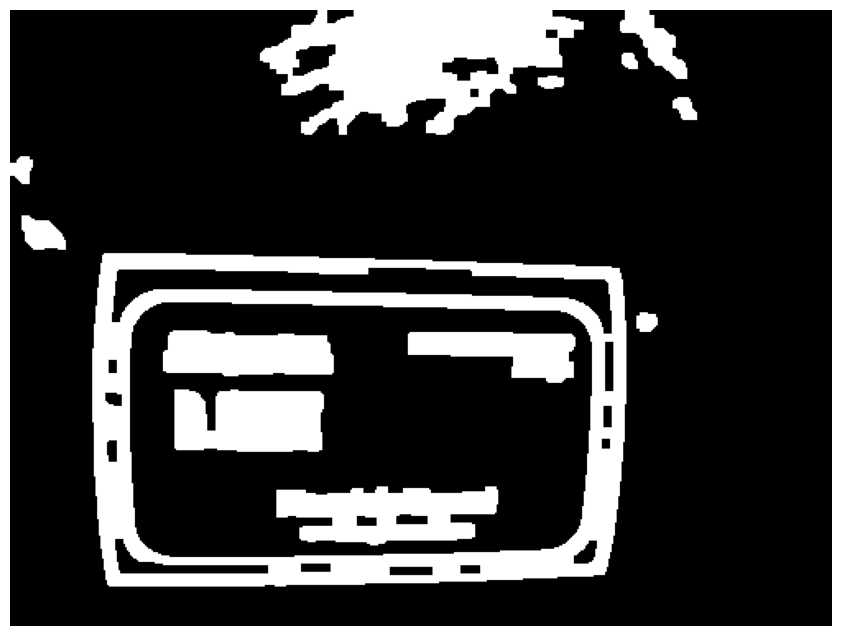

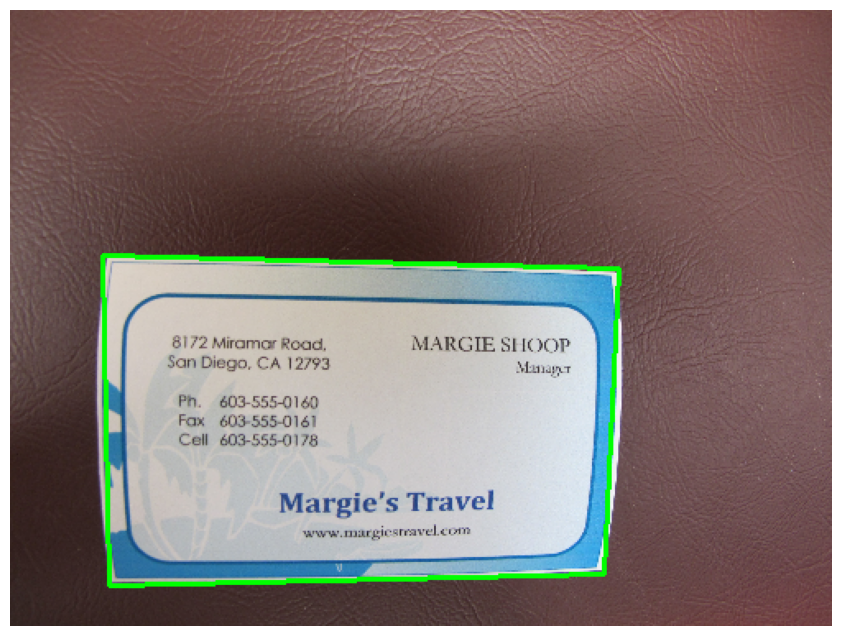

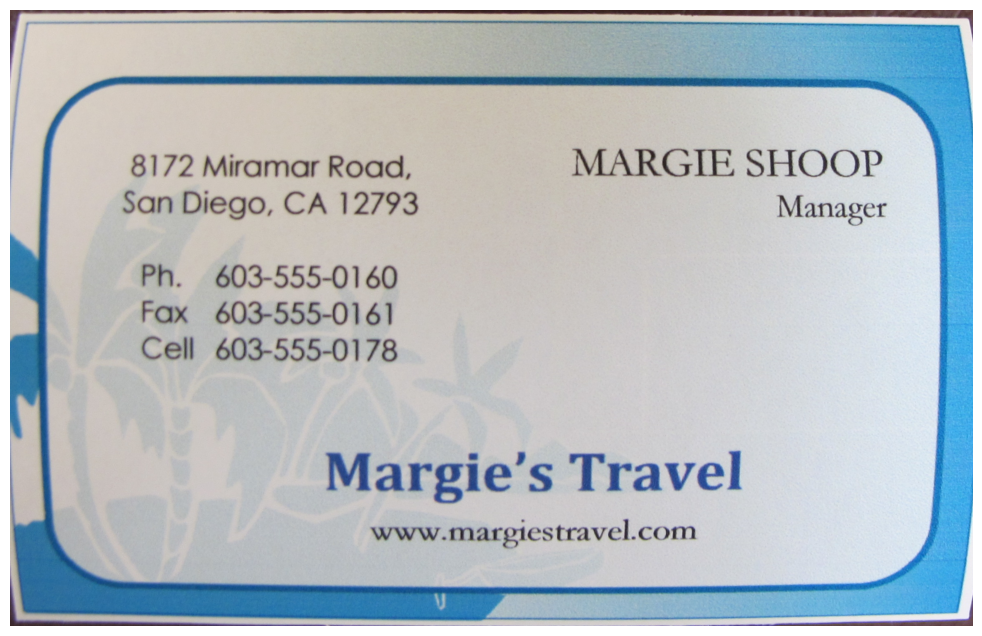

In [199]:
img = cv2.imread('images/015.jpg')
wrap_img, four_points, cnt_img, edge_img = document_scanner(img)
show_img(edge_img)
show_img(cnt_img)
show_img(wrap_img)

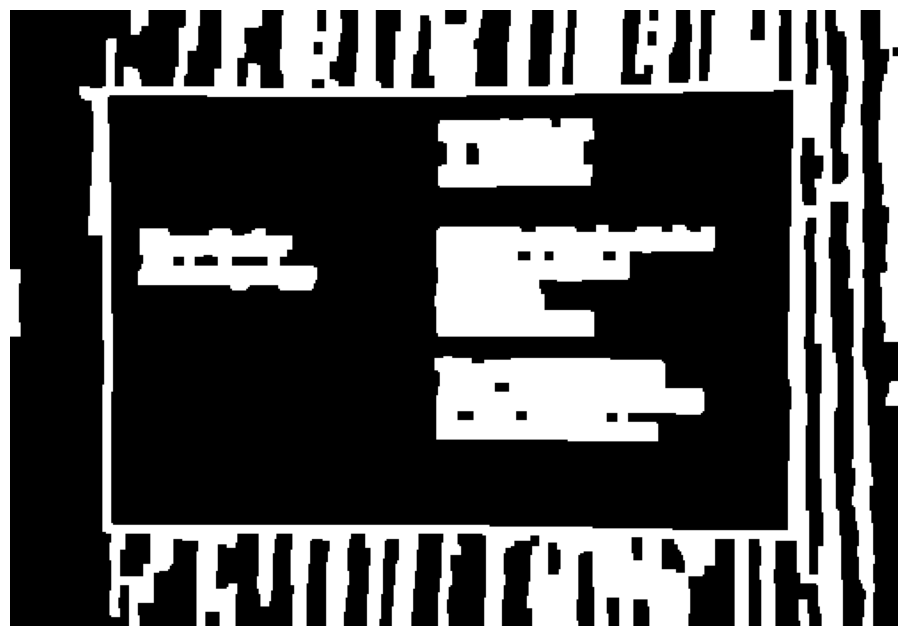

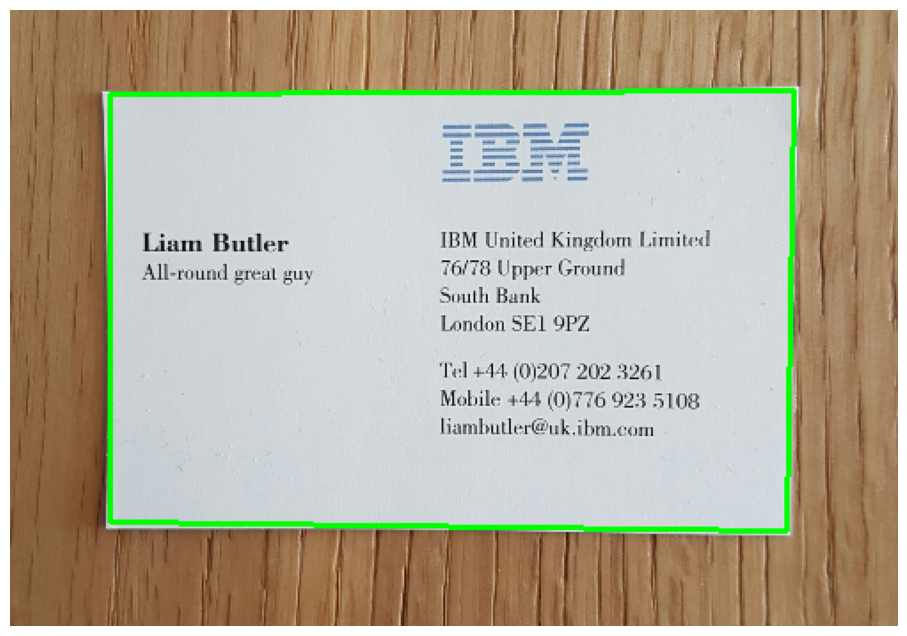

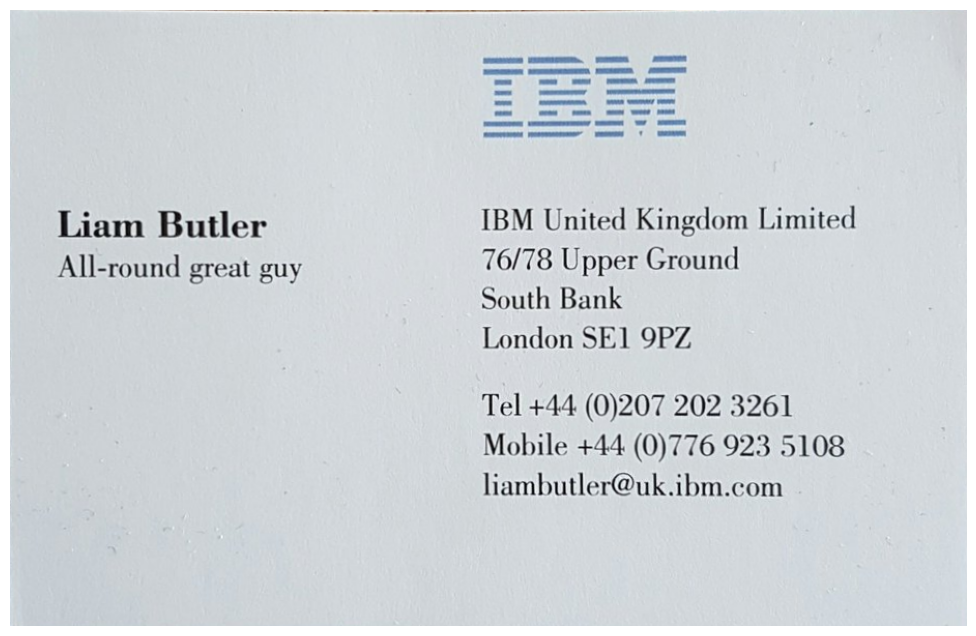

In [200]:
img = cv2.imread('images/001.jpg')
wrap_img, four_points, cnt_img, edge_img = document_scanner(img)
show_img(edge_img)
show_img(cnt_img)
show_img(wrap_img)

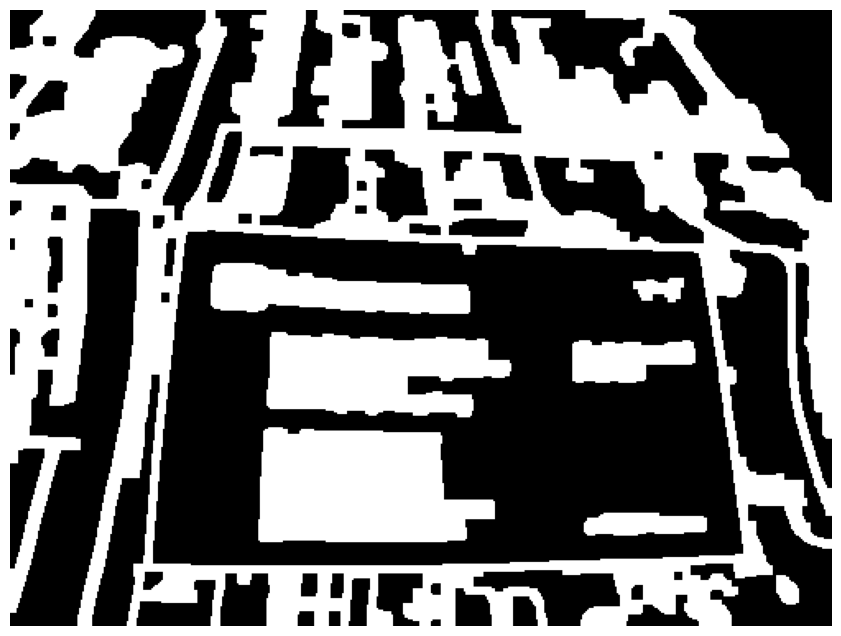

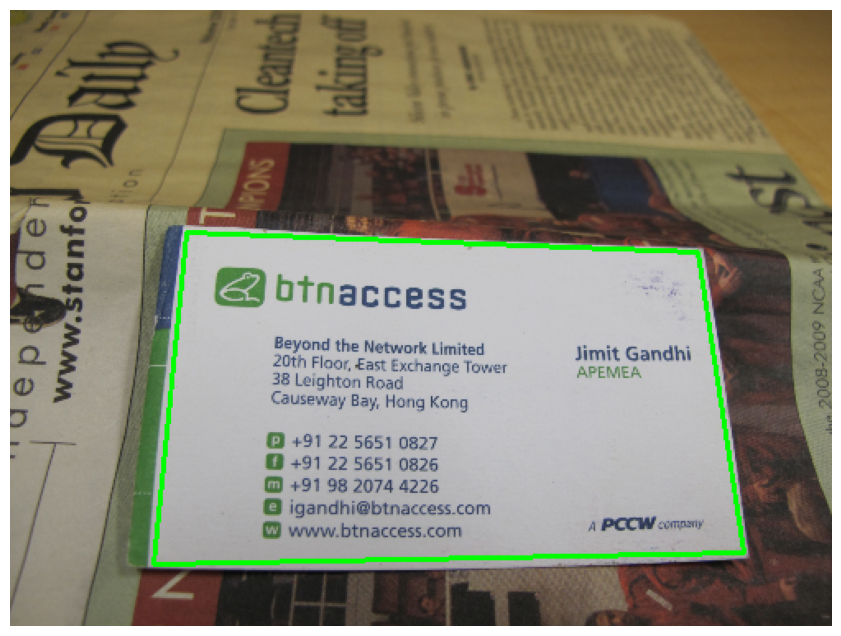

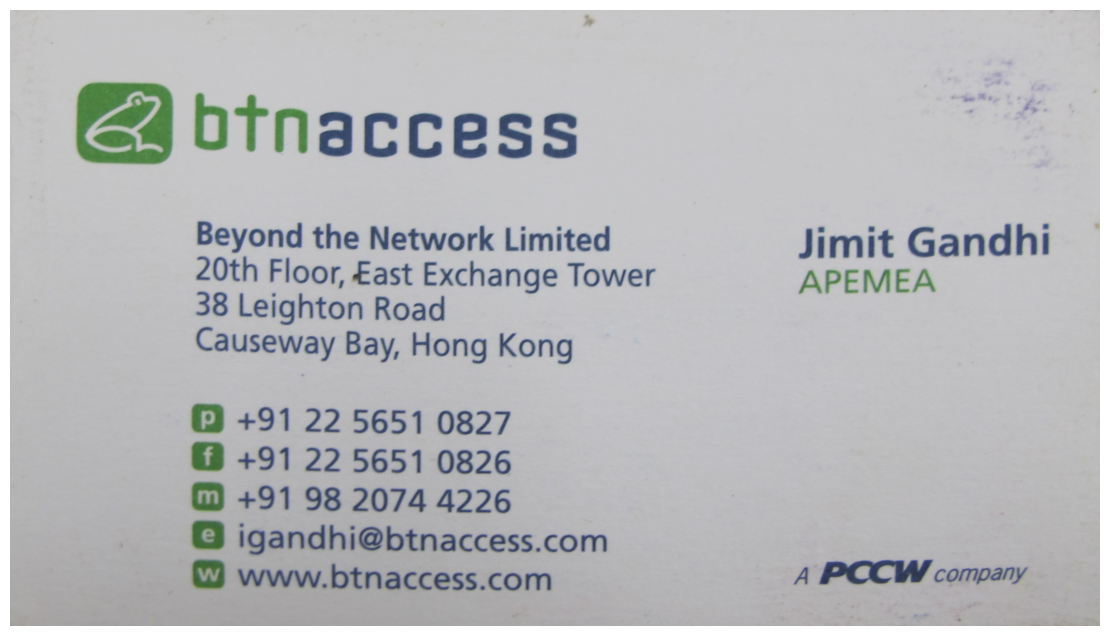

In [201]:
img = cv2.imread('images/033.jpg')
wrap_img, four_points, cnt_img, edge_img = document_scanner(img)
show_img(edge_img)
show_img(cnt_img)
show_img(wrap_img)

## Magic Color

In [202]:
def apply_brightness_contrast(input_img, brightness=0, contrast=0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127) / (127 * (131-contrast))
        alpha_c = f
        gamma_c = 127 * (1-f)
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
    return buf

(-0.5, 2619.5, 1480.5, -0.5)

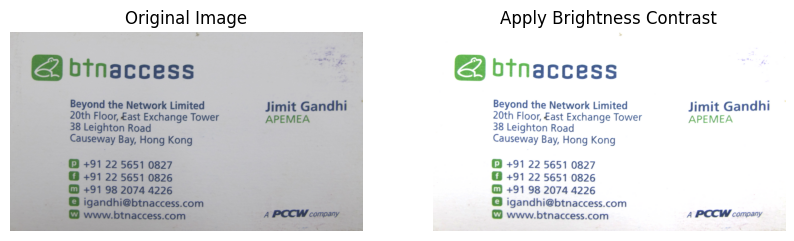

In [203]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(wrap_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis("off")

magic_img = apply_brightness_contrast(wrap_img, 50, 40)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(magic_img, cv2.COLOR_BGR2RGB))
plt.title('Apply Brightness Contrast')
plt.axis("off")

## Predictions

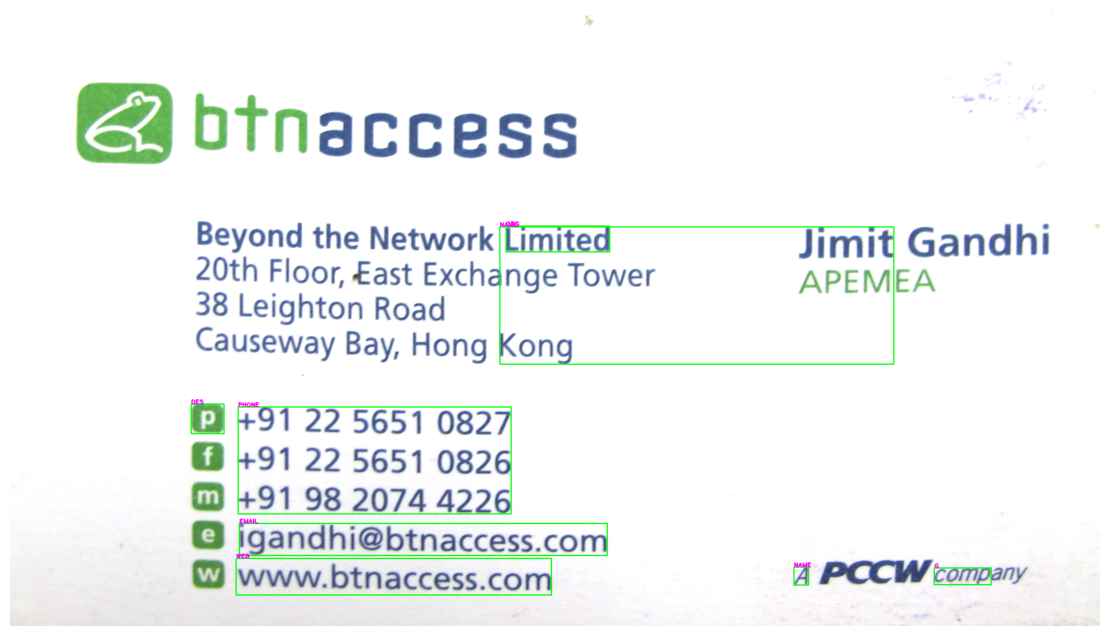

In [204]:
import predictions as pred
img_bb, results = pred.get_predictions(magic_img)
show_img(img_bb)


In [205]:
results

{'NAME': ['Jimit', 'Kong', 'A'],
 'ORG': ['Limited'],
 'DES': [''],
 'PHONE': ['912256510827912256510826919820744226'],
 'EMAIL': ['igandhi@btnaccess.com'],
 'WEB': ['www.btnaccess.com']}